In [128]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.metrics import (mean_squared_error, max_error, 
                             confusion_matrix, ConfusionMatrixDisplay, 
                             classification_report, make_scorer, matthews_corrcoef,
                            f1_score, recall_score, precision_score, accuracy_score)
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import joblib
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("biodegradable_a.csv")
df.shape

(4564, 42)

In [3]:
X = df.drop(columns="Biodegradable")
y = df.Biodegradable

In [4]:
#new biodegradable (new_x):  1 if RB else -1
y = y.map(lambda x: 1 if x=='RB' else -1)

In [5]:
#Criação do train + test e validation set
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size=0.25, random_state=22)

In [6]:
y_Train.value_counts()

 1    2858
-1     565
Name: Biodegradable, dtype: int64

In [ ]:
X_Train.info()

In [8]:
print(
    f"Maximum missing attributes on the rows: {X_Train.isna().sum(axis=1).max()}"
)

Maximum missing attributes on the rows: 6


In [9]:
missing_cols = X_Train.isna().sum()
missing_cols[missing_cols>0]

F01         389
C           573
nCp         497
HyWi_B      347
F03_CO       27
Me          332
nCIR        373
SpMax_A     494
SdO         166
nCrt        177
SpMax_B    1003
Psi_i_A     317
nX          513
dtype: int64

Number of null values is significant on many columns ( > 25% ) <br>
Droping features is not an option for dealing with missing data, because we do not have the knowledge yet if they have relation with the class we want to predict<br>

However, per sample, 6 out of 40 attributes doesn't seem very significant.
This before the feature selection.

## Classification Models

- [x] SVM
- [x] DecisionTree
- [x] Bagging:
    - RandomForest
    - KNN

# Testing Imputation Models

In [10]:
X_train_no_nans = X_Train.dropna()

In [11]:
X_train_no_nans.shape

(698, 41)

In [12]:
X_Train.shape

(3423, 41)

The difference in the number of rows, from the variable *X_train_not_nan* and the variable *X_train* indicates that a huge number of instances are missing at least one of the features, hence droping rows is not a viable option

In [13]:
#probability of having a none on a certain
# feature, based in the training set
priors = X_Train.isna().sum()/X_Train.shape[0]
priors.shape

(41,)

In [34]:
#returns an array with true/false values
# with shape of X
np.random.seed(12)
def get_mask(X,priors):
    masks = np.empty(shape = X.shape, dtype=np.bool_)
    for i, p in enumerate(priors):
        masks[:, i] = np.random.choice((True,False), size=masks.shape[0], p=(p,1-p))
    return masks

N = 500
masks = [get_mask(X_train_no_nans, priors) for _ in range(N)]

In [87]:
#change scaler here
# MinMaxScaler(), StandardScaler(), PowerTransformer()
scaler = PowerTransformer()

scaler.fit(X_train_no_nans)
X_train_no_nans_scaled = pd.DataFrame(data = scaler.transform(X_train_no_nans),
                                      columns=X_train_no_nans.columns)

In [88]:
imputers = (
        SimpleImputer(),
        SimpleImputer(strategy="median"),
        KNNImputer()
)
labels = ["SimpleImpute_mean", "SimpleImpute_median", "KNN"]

results = pd.DataFrame(index=X_train_no_nans.columns)
#simulate nans over columns N times, for each imputer
#and compare with real values
for label, model in zip(labels,imputers):
    errors=pd.DataFrame(columns = X_train_no_nans.columns)
    for _ in range(N):
        X_masked = X_train_no_nans_scaled.mask(masks[_])
        
        model = model.fit(X_masked)
        X_imputed = model.transform(X_masked)

        errors.loc[_] = dict(zip(X_train_no_nans_scaled.columns, 
                                 mean_squared_error(X_train_no_nans_scaled, 
                                                    X_imputed, 
                                                    squared=False, 
                                                    multioutput="raw_values")
                                ))
    results[label] = errors.mean()

In [ ]:
results[results>0].dropna()

In [90]:
results[results>0].dropna().sum()

SimpleImpute_mean      4.039438
SimpleImpute_median    4.155561
KNN                    1.915459
dtype: float64

The *KNNImputer* is the one that better predicts the missing values, according to this test, since it is the one that gets closer results for every feature with missing values, which results having the least summed error. <br>
Not many different parameters were used for it, so it can probably achieve even better results.

In [91]:
imputers = (
        KNNImputer(n_neighbors=i) for i in range(3,11)
)

labels = [f"KNN_{i}_neighbors" for i in range(3,11)]

results = pd.DataFrame(index=X_train_no_nans.columns)
for label, model in zip(labels,imputers):
    errors=pd.DataFrame(columns = X_train_no_nans.columns)
    for _ in range(N):
        X_masked = X_train_no_nans_scaled.mask(masks[_])
        
        model = model.fit(X_masked)
        X_imputed = model.transform(X_masked)

        errors.loc[_] = dict(zip(X_train_no_nans_scaled.columns, 
                                 mean_squared_error(X_train_no_nans_scaled, 
                                                    X_imputed, 
                                                    squared=False, 
                                                    multioutput="raw_values")
                                ))
    results[label] = errors.mean()

In [ ]:
results[results>0].dropna()

In [93]:
results[results>0].dropna().sum()

KNN_3_neighbors     1.791669
KNN_4_neighbors     1.860618
KNN_5_neighbors     1.915459
KNN_6_neighbors     1.969359
KNN_7_neighbors     2.016680
KNN_8_neighbors     2.058735
KNN_9_neighbors     2.094052
KNN_10_neighbors    2.124517
dtype: float64

In [94]:
results[results>0].dropna().sum().idxmin()

'KNN_3_neighbors'

## Imputer Results

We can see that KNN has the minimum error in every scalling method, so this method will be used for all the normalizers. <br>
For all the cases tested, the 3-NN imputer was the one that obtained better results

# Scale and impute the rest of the data

Perform imputation of missing values before scaling, as scaling could lead to distorted data if the missing values are not first replaced. This is because some calculations may include the missing values and their presence could lead to skewed results.

# Feature Selection with Random Forest Selector

Fitting a tree find the best features.

In [97]:
(X_Train.std()==0).any()

False

There are no features with constant values, so there is no need to drop any column

In [84]:
#correlation with output
np.abs(pd.concat((X_Train, y_Train), axis=1).corr()["Biodegradable"]).sort_values(ascending=False)[1:6]

nHM       0.466193
C_026     0.422011
F02_CN    0.417339
B03       0.399126
nCb       0.388747
Name: Biodegradable, dtype: float64

In [85]:
(X_Train.std()).sort_values(ascending=False)[:5]

SdO       9.815021
C         8.319025
F03_CO    3.597125
nCIR      2.863329
TI2_L     2.502184
dtype: float64

In [86]:
def get_sorted_labels(col_names : list[str], pipeline: Pipeline) -> list[str]:
    #join names and scores in tuples (column, score)
    label_scores = zip(col_names, pipeline["selector"].estimator_.feature_importances_)
    
    #sort tuples accoding to value in index 1 (column, -> score <-)
    sorted_labels = sorted(label_scores, key = lambda x: x[1], reverse=True)
    
    return sorted_labels

In [96]:
model = Pipeline([("scaler", MinMaxScaler()),
                  ("imputer", KNNImputer(n_neighbors=3)),
                  ("selector", SelectFromModel(
                      estimator = RandomForestClassifier(
                          random_state=0
                      ),
                      threshold = -np.inf
                  ))
                 ])

model.fit(X_Train, y_Train)
get_sorted_labels(X_Train.columns, model)[:5]

[('nHM', 0.09019284019639669),
 ('nX', 0.07206351164853046),
 ('F04', 0.05212956069593135),
 ('nCb', 0.051330007369609264),
 ('SpMax_B', 0.04912126993703623)]

# Classification Models

In [126]:
def conf_mat(y_test, pred):
    ConfusionMatrixDisplay(
        confusion_matrix(y_test, pred)
    ).plot()

In [99]:
def scatter_3d(x, y, z, score, xlabel="", ylabel="", zlabel="", ):
    f, ax = plt.subplots(figsize=(8,8), subplot_kw={"projection":"3d"})
    im = ax.scatter(x, 
                    y, 
                    z, 
                   c = score,
                    #s=50
              )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)

    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel('MCC Score', rotation=0)
    f.tight_layout()

In [100]:
def scatter_2d(x, y, score, xlabel="", ylabel="", ax = None, cb=False):
    if ax==None:
        f, ax = plt.subplots()
    im = ax.scatter(x,y, c=score)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if cb:
        cbar = plt.colorbar(im)
        cbar.ax.set_ylabel("MCC Scores", rotation=0)

In [102]:
filter_ = lambda key,value, arr: list(filter(lambda x: x[key]==value, arr))
map_ = lambda key, arr: list(map(lambda x: x[key], arr))
best_score = lambda grid_search : max(grid_search.cv_results_["mean_test_score"])

def index_from(label, arr):
    for i in range(len(arr)):
        if arr[i]["classifier__criterion"] == label:
            yield i

## Random Forest Classifier

In [98]:
#select filename to save the grid_search object
FILENAME = "MinMax-RF_v3"
if os.path.exists(FILENAME):
    #if file exists, load it
    search_results = joblib.load(FILENAME)
else:
    #change scaler here
    # MinMaxScaler(), StandardScaler(), PowerTransformer()
    scaler = MinMaxScaler()
    pipeline = [
                ("scaler", scaler),
                ("imputer", KNNImputer(n_neighbors=3)),
                ("selector", SelectFromModel(
                    estimator = RandomForestClassifier(
                        random_state=0
                    ),
                    threshold=-np.inf,
                )),
                ("classifier", RandomForestClassifier(
                        min_samples_leaf= 1,
                ))
               ]

    model = Pipeline(pipeline)

    grid = {
        #{pipeline_name}__{feature_name} : [ ... ]
        "selector__max_features": range(22, 37+1, 1),
        "classifier__criterion": ["gini", "entropy"],
        "classifier__max_depth" : range(25, 35+1, 1),
        #classifier__min_samples_leaf : range(1,10)
    } 

    search_results = GridSearchCV(estimator = model,
                                  param_grid=grid,
                                  cv = 9,
                                  scoring=make_scorer(matthews_corrcoef),
                                  n_jobs=-1, #number of processes; -1 --> use all
                                  verbose=10, #text information
                                  return_train_score=True
                                 )
    search_results.fit(X_Train, y_Train)
    #save file
    joblib.dump(search_results, FILENAME)

In [103]:
search_results.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 31,
 'selector__max_features': 36}

In [107]:
print(f"Best Parameters Test Score: {best_score(search_results):.03}")

Best Parameters Test Score: 0.888


In [ ]:
#only data with certain criteria 
data = filter_("classifier__criterion", "gini", search_results.cv_results_["params"])

x_depth = map_("classifier__max_depth", data)
y_split = map_("classifier__min_samples_split", data)
z_feat = map_("selector__max_features", data)

idx = list(index_from("gini", search_results.cv_results_["params"]))
score = search_results.cv_results_["mean_test_score"][idx]

In [ ]:
%matplotlib inline

scatter_3d(x_depth,
           y_split,
           z_feat,
           score,
           xlabel="Tree Max. Depth",
           ylabel="Min. Samples Split",
           zlabel="Max nº of Features",
)

## K-Nearest Neighbours with Bagging

In [111]:
FILENAME = "Std-KNN_v3"
if os.path.exists(FILENAME):
    #if file exists, load it
    search_results = joblib.load(FILENAME, )
else:
    #change scaler here
    # MinMaxScaler(), StandardScaler(), PowerTransformer()
    scaler = StandardScaler()
    pipeline = [
                ("scaler", scaler),
                ("imputer", KNNImputer(n_neighbors=3)),
                ("selector", SelectFromModel(
                    estimator = RandomForestClassifier(
                        random_state=0
                    ),
                    threshold=-np.inf,
                )),
                ("classifier", BaggingClassifier(base_estimator=KNeighborsClassifier()))
               ]

    model = Pipeline(pipeline)

    grid = {
        #{pipeline_name}__{feature_name} : [ ... ]
        "selector__max_features": range(25,30), #testado de 1 a 32
        "classifier__n_estimators": range(15,19), #testado de 1 a 32
        "classifier__base_estimator__n_neighbors": range(2,4), #testado de 1 a 25
        "classifier__base_estimator__weights": ["distance"], #testado distance e uniforme
        "classifier__base_estimator__p":range(1,2) #testado de 1 a 5
    } 

    search_results = GridSearchCV(estimator = model,
                                  param_grid=grid,
                                  cv = 9,
                                  scoring=make_scorer(matthews_corrcoef),
                                  n_jobs=-1, #number of processes; -1 --> use all
                                  verbose=10, #text information
                                  return_train_score=True
                                 )
    search_results.fit(X_Train, y_Train)
    #save file
    joblib.dump(search_results, FILENAME)

In [113]:
search_results.best_params_

{'classifier__base_estimator__n_neighbors': 2,
 'classifier__base_estimator__p': 1,
 'classifier__base_estimator__weights': 'distance',
 'classifier__n_estimators': 15,
 'selector__max_features': 27}

In [112]:
best_score(search_results)

0.8562796465074833

## Support Vector Machine

In [115]:
FILENAME = "MinMax_SVM_v7"
if os.path.exists(FILENAME):
    #if file exists, load it
    search_results = joblib.load(FILENAME)
else:
    #change scaler here
    # MinMaxScaler(), StandardScaler(), PowerTransformer()
    scaler = MinMaxScaler()
    pipeline = [
                ("scaler", scaler),
                ("imputer", KNNImputer(n_neighbors=3)),
                ("selector", SelectFromModel(
                    estimator = RandomForestClassifier(
                        random_state=0
                    ),
                    threshold=-np.inf,
                )),
                ("classifier",SVC())
               ]

    model = Pipeline(pipeline)

    grid = {
        "selector__max_features": [27],
        "classifier__C":  range(8,12,1),  #from 1e-2 to 1e10, 5 steps
        "classifier__gamma": range(8,12,1),
        "classifier__kernel": ["rbf"]
    } 

    search_results = GridSearchCV(estimator = model,
                                  param_grid=grid,
                                  cv = 9,
                                  scoring=make_scorer(matthews_corrcoef),
                                  n_jobs=3, #number of processes; -1 --> use all
                                  verbose=10, #text information
                                  return_train_score=True
                                 )
    search_results.fit(X_Train, y_Train)
    #save file
    joblib.dump(search_results, FILENAME)

In [116]:
search_results.best_params_

{'classifier__C': 8,
 'classifier__gamma': 11,
 'classifier__kernel': 'rbf',
 'selector__max_features': 27}

In [118]:
print(f"Best Parameters Test Score: {best_score(search_results):.03}")

Best Parameters Test Score: 0.889


## Decision Tree Classifier

In [119]:
FILENAME = "PowerTransformer-DT"
if os.path.exists(FILENAME):
    #if file exists, load it
    search_results = joblib.load(FILENAME)
else:
    pipeline = [
                ("scaler", PowerTransformer()),
                ("imputer", KNNImputer(n_neighbors=3)),
                ("selector", SelectFromModel(
                    estimator = RandomForestClassifier(
                        random_state=0
                    ),
                    threshold=-np.inf,
                )),
                ("classifier", DecisionTreeClassifier(
                        min_samples_leaf= 1,
                    min_samples_split=3
                ))
               ]

    model = Pipeline(pipeline)

    grid = {
        #{pipeline_name}__{feature_name} : [ ... ]
         'selector__max_features': range(20, 41, 10),
         'classifier__criterion': ['gini', 'entropy'],
         'classifier__max_depth': range(10, 61, 10),
         'classifier__min_samples_split': range(2, 10)
    } 

    search_results = GridSearchCV(estimator = model,
                                  param_grid=grid,
                                  cv = 9,
                                  scoring=make_scorer(matthews_corrcoef),
                                  n_jobs=-1, #number of processes; -1 --> use all
                                  verbose=10, #text information
                                  return_train_score=True,
                                  pre_dispatch=2,
                                  error_score=0
                                 )
    search_results.fit(X_Train, y_Train)
    #save file
    joblib.dump(search_results, FILENAME)

In [120]:
search_results.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 20,
 'classifier__min_samples_split': 2,
 'selector__max_features': 40}

In [121]:
print(f"Best Parameters Test Score: {best_score(search_results):.03}")

Best Parameters Test Score: 0.822


# Validating Best Model

In [124]:
best_model = Pipeline([("scaler", MinMaxScaler()),
                       ("imputer", KNNImputer(n_neighbors=3)),
                       ("selector", SelectFromModel(
                           estimator=RandomForestClassifier(
                               random_state=0
                           ),
                           threshold = -np.inf,
                           max_features=27
                       )),
                       ("classifier", SVC(
                           C=8,
                           gamma=11)
                       )])
best_model.fit(X_Train, y_Train);

In [125]:
preds = best_model.predict(X_Test)

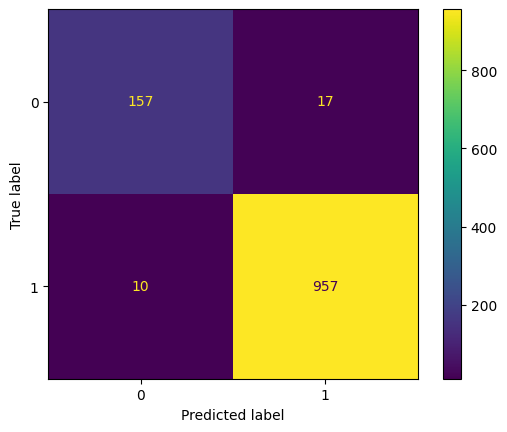

In [127]:
conf_mat(y_Test, preds)

In [131]:
print(f"""MCC = {matthews_corrcoef(y_Test,preds):.3f}
Precision = {precision_score(y_Test, preds):.3f}
Recall = {recall_score(y_Test, preds):.3f}
F1 = {f1_score(y_Test, preds):.3f}
Accuracy = {accuracy_score(y_Test, preds):.3f}
""")

MCC = 0.907
Precision = 0.983
Recall = 0.990
F1 = 0.986
Accuracy = 0.976

